# SNGAN

Below implementation uses SNGAN This uses hinge as a loss function and uses spectral norm implementation form pytorch library.

In [1]:
pip install torch==1.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cu121
    Uninstalling torch-2.4.0+cu121:
      Successfully uninstalled torch-2.4.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0+cu121 requires torch==2.4.0, but you have torch 1.11.0 which is incompatible.
torchvision 0.19.0+cu121 requires torch==2.4.0, but you have torch 1.11.0 which is incompatible.


In [2]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
pip install tensorboardX  tqdm pytorch_image_generation_metrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.5 MB/s eta 0:00:00


In [8]:
import math

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.nn.utils.spectral_norm import spectral_norm


class Generator(nn.Module):
    def __init__(self, z_dim, M=4):
        super().__init__()
        self.M = M
        self.linear = nn.Linear(z_dim, M * M * 512)
        self.main = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh())
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                init.normal_(m.weight, std=0.02)
                init.zeros_(m.bias)

    def forward(self, z, *args, **kwargs):
        x = self.linear(z)
        x = x.view(x.size(0), -1, self.M, self.M)
        x = self.main(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, M=32):
        super().__init__()
        self.M = M

        self.main = nn.Sequential(
            # M
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            # M / 2
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            # M / 4
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            # M / 8
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.linear = nn.Linear(M // 8 * M // 8 * 512, 1)
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                init.normal_(m.weight, std=0.02)
                init.zeros_(m.bias)
                spectral_norm(m)

    def forward(self, x, *args, **kwargs):
        x = self.main(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x


class Generator32(Generator):
    def __init__(self, z_dim):
        super().__init__(z_dim, M=4)


class Discriminator32(Discriminator):
    def __init__(self):
        super().__init__(M=32)



In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Hinge(nn.Module):
    def forward(self, pred_real, pred_fake=None):
        if pred_fake is not None:
            loss_real = F.relu(1 - pred_real).mean()
            loss_fake = F.relu(1 + pred_fake).mean()
            return loss_real + loss_fake
        else:
            loss = -pred_real.mean()
            return loss


In [10]:
import random

import torch
import numpy as np
from tqdm import trange


def generate_imgs(net_G, device, z_dim=128, size=5000, batch_size=128):
    net_G.eval()
    imgs = []
    with torch.no_grad():
        for start in trange(0, size, batch_size,
                            desc='Evaluating', ncols=0, leave=False):
            end = min(start + batch_size, size)
            z = torch.randn(end - start, z_dim).to(device)
            imgs.append(net_G(z).cpu())
    net_G.train()
    imgs = torch.cat(imgs, dim=0)
    imgs = (imgs + 1) / 2
    return imgs


def infiniteloop(dataloader):
    while True:
        for x, _ in iter(dataloader):
            yield x


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

In [12]:
import os

import torch
import torch.optim as optim
from absl import flags, app
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from tensorboardX import SummaryWriter
from tqdm import trange
from pytorch_image_generation_metrics import get_inception_score_and_fid

net_G_models = {
    'cnn32': Generator32,
}

net_D_models = {
    'cnn32': Discriminator32,
}

loss_fns = {
    'hinge': Hinge
}


# model and training
# Model and training settings
dataset = 'cifar10'  # Dataset options: ['cifar10', 'stl10']
arch = 'cnn32'  # Architecture options: net_G_models.keys() (e.g., 'res32', 'cnn32')
total_steps = 10000  # Total number of training steps
batch_size = 128  # Batch size
lr_G = 2e-4  # Learning rate for the generator
lr_D = 2e-4  # Learning rate for the discriminator
betas = [0.0, 0.9]  # Betas for the Adam optimizer
n_dis = 1  # Update the generator every 'n_dis' steps
z_dim = 100  # Latent space dimension
seed = 0  # Random seed

# Logging settings
eval_step = 5000  # Evaluate FID and Inception Score every 'eval_step' steps
sample_step = 500  # Sample images every 'sample_step' steps
sample_size = 64  # Number of images to sample
logdir = './logs/SNGAN_CIFAR10_RES'  # Log directory
record = True  # Record Inception Score and FID
fid_cache = './stats/cifar10.train.npz'  # FID cache

# Generation settings
generate = False  # Whether to generate images or not
pretrain = None  # Path to the pretrained model for generation
output = './outputs'  # Directory for output images
num_images = 50000  # Number of images to generate


device = torch.device('cuda:0')
fid_scores = []
IS_scores = []


def generate():
    net_G = net_G_models[arch](z_dim).to(device)
    net_G.load_state_dict(torch.load(pretrain)['net_G'])
    net_G.eval()

    counter = 0
    os.makedirs(output)
    with torch.no_grad():
        for start in trange(
                0, num_images, batch_size, dynamic_ncols=True):
            batch_size = min(batch_size, num_images - start)
            z = torch.randn(batch_size, z_dim).to(device)
            x = net_G(z).cpu()
            x = (x + 1) / 2
            for image in x:
                save_image(
                    image, os.path.join(output, '%d.png' % counter))
                counter += 1


def train():
    dataset = datasets.CIFAR10(
            './data', train=True, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                transforms.Lambda(lambda x: x + torch.rand_like(x) / 128)
            ]))


    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4,
        drop_last=True)

    net_G = net_G_models[arch](z_dim).to(device)
    net_D = net_D_models[arch]().to(device)
    loss_fn = loss_fns['hinge']()

    optim_G = optim.Adam(net_G.parameters(), lr=lr_G, betas=betas)
    optim_D = optim.Adam(net_D.parameters(), lr=lr_D, betas=betas)
    sched_G = optim.lr_scheduler.LambdaLR(
        optim_G, lambda step: 1 - step / total_steps)
    sched_D = optim.lr_scheduler.LambdaLR(
        optim_D, lambda step: 1 - step / total_steps)

    os.makedirs(os.path.join(logdir, 'sample'))
    writer = SummaryWriter(os.path.join(logdir))
    sample_z = torch.randn(sample_size, z_dim).to(device)

    real, _ = next(iter(dataloader))
    grid = (make_grid(real[:sample_size]) + 1) / 2
    writer.add_image('real_sample', grid)

    looper = infiniteloop(dataloader)
    with trange(1, total_steps + 1, desc='Training', ncols=0) as pbar:
        for step in pbar:
            # Discriminator
            for _ in range(n_dis):
                with torch.no_grad():
                    z = torch.randn(batch_size, z_dim).to(device)
                    fake = net_G(z).detach()
                real = next(looper).to(device)
                net_D_real = net_D(real)
                net_D_fake = net_D(fake)
                loss = loss_fn(net_D_real, net_D_fake)

                optim_D.zero_grad()
                loss.backward()
                optim_D.step()

                pbar.set_postfix(loss='%.4f' % loss)
            writer.add_scalar('loss', loss, step)

            # Generator
            z = torch.randn(batch_size * 2, z_dim).to(device)
            loss = loss_fn(net_D(net_G(z)))

            optim_G.zero_grad()
            loss.backward()
            optim_G.step()

            sched_G.step()
            sched_D.step()

            if step == 1 or step % sample_step == 0:
                fake = net_G(sample_z).cpu()
                grid = (make_grid(fake) + 1) / 2
                writer.add_image('sample', grid, step)
                save_image(grid, os.path.join(
                    logdir, 'sample', '%d.png' % step))

            if step == 1 or step % eval_step == 0:
                torch.save({
                    'net_G': net_G.state_dict(),
                    'net_D': net_D.state_dict(),
                    'optim_G': optim_G.state_dict(),
                    'optim_D': optim_D.state_dict(),
                    'sched_G': sched_G.state_dict(),
                    'sched_D': sched_D.state_dict(),
                }, os.path.join(logdir, 'model.pt'))
                if record:
                    imgs = generate_imgs(
                        net_G, device, z_dim,
                        num_images, batch_size)
                    IS, FID = get_inception_score_and_fid(
                        imgs, fid_cache, verbose=True)
                    fid_scores.append([step, FID])
                    IS_scores.append([step, IS])
                    pbar.write(
                        "%s/%s Inception Score: %.3f(%.5f), "
                        "FID: %6.3f" % (
                            step, total_steps, IS[0], IS[1], FID))
                    writer.add_scalar('Inception_Score', IS[0], step)
                    writer.add_scalar('Inception_Score_std', IS[1], step)
                    writer.add_scalar('FID', FID, step)
    writer.close()




In [14]:
train()

100%|██████████| 170498071/170498071 [00:03<00:00, 47351187.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training:   0% 0/10000 [00:01<?, ?it/s, loss=1.9987]
Evaluating:   0% 0/391 [00:00<?, ?it/s]
Evaluating:   1% 4/391 [00:00<00:10, 35.19it/s]
Evaluating:   2% 8/391 [00:00<00:11, 33.48it/s]
Evaluating:   3% 12/391 [00:00<00:11, 32.91it/s]
Evaluating:   4% 16/391 [00:00<00:11, 32.75it/s]
Evaluating:   5% 20/391 [00:00<00:11, 32.53it/s]
Evaluating:   6% 24/391 [00:00<00:11, 32.40it/s]
Evaluating:   7% 28/391 [00:00<00:11, 32.26it/s]
Evaluating:   8% 32/391 [00:00<00:11, 31.86it/s]
Evaluating:   9% 36/391 [00:01<00:11, 31.9

get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0% 1/10000 [03:51<642:42:58, 231.40s/it, loss=1.9987]

1/10000 Inception Score: 1.017(0.00010), FID: 457.122


Training:  50% 4999/10000 [35:55<32:01,  2.60it/s, loss=1.5183]
Evaluating:   0% 0/391 [00:00<?, ?it/s]
Evaluating:   1% 4/391 [00:00<00:11, 32.63it/s]
Evaluating:   2% 8/391 [00:00<00:12, 30.49it/s]
Evaluating:   3% 12/391 [00:00<00:12, 29.72it/s]
Evaluating:   4% 15/391 [00:00<00:12, 29.16it/s]
Evaluating:   5% 18/391 [00:00<00:12, 29.32it/s]
Evaluating:   6% 22/391 [00:00<00:12, 29.67it/s]
Evaluating:   6% 25/391 [00:00<00:12, 29.39it/s]
Evaluating:   7% 28/391 [00:00<00:12, 28.86it/s]
Evaluating:   8% 31/391 [00:01<00:12, 28.81it/s]
Evaluating:   9% 34/391 [00:01<00:12, 28.73it/s]
Evaluating:   9% 37/391 [00:01<00:12, 28.69it/s]
Evaluating:  10% 40/391 [00:01<00:12, 28.39it/s]
Evaluating:  11% 43/391 [00:01<00:12, 28.32it/s]
Evaluating:  12% 46/391 [00:01<00:12, 28.46it/s]
Evaluating:  13% 49/391 [00:01<00:11, 28.59it/s]
Evaluating:  13% 52/391 [00:01<00:11, 28.60it/s]
Evaluating:  14% 55/391 [00:01<00:11, 28.43it/s]
Evaluating:  15% 58/391 [00:02<00:11, 28.43it/s]
Evaluating:  16%

get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:  50% 5000/10000 [39:48<97:32:40, 70.23s/it, loss=1.5183]

5000/10000 Inception Score: 5.112(0.03519), FID: 57.529


Training: 100% 9999/10000 [1:11:53<00:00,  2.61it/s, loss=1.5665]
Evaluating:   0% 0/391 [00:00<?, ?it/s]
Evaluating:   1% 4/391 [00:00<00:11, 32.61it/s]
Evaluating:   2% 8/391 [00:00<00:12, 29.96it/s]
Evaluating:   3% 12/391 [00:00<00:12, 29.41it/s]
Evaluating:   4% 15/391 [00:00<00:12, 29.10it/s]
Evaluating:   5% 18/391 [00:00<00:12, 28.89it/s]
Evaluating:   5% 21/391 [00:00<00:12, 28.70it/s]
Evaluating:   6% 25/391 [00:00<00:12, 29.28it/s]
Evaluating:   7% 28/391 [00:00<00:12, 28.63it/s]
Evaluating:   8% 31/391 [00:01<00:12, 28.98it/s]
Evaluating:   9% 34/391 [00:01<00:12, 28.92it/s]
Evaluating:   9% 37/391 [00:01<00:12, 28.82it/s]
Evaluating:  10% 40/391 [00:01<00:12, 28.74it/s]
Evaluating:  11% 43/391 [00:01<00:12, 28.81it/s]
Evaluating:  12% 46/391 [00:01<00:12, 28.71it/s]
Evaluating:  13% 49/391 [00:01<00:11, 28.58it/s]
Evaluating:  13% 52/391 [00:01<00:11, 28.66it/s]
Evaluating:  14% 55/391 [00:01<00:11, 28.54it/s]
Evaluating:  15% 58/391 [00:02<00:11, 28.55it/s]
Evaluating:  1

get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

Training: 100% 10000/10000 [1:15:47<00:00,  2.20it/s, loss=1.5665]


10000/10000 Inception Score: 6.176(0.04591), FID: 43.622


In [28]:
def plot_graph(data_fid, title, xlabel, ylabel):
    import matplotlib.pyplot as plt
    import numpy as np

    # Extracting iterations and scores for FID
    iterations_fid = np.array([point[0] for point in data_fid])
    fid_scores = np.array([point[1] for point in data_fid])

    # Plotting FID and IS on the same graph
    plt.figure(figsize=(10, 6))

    # Plot FID
    plt.plot(iterations_fid, fid_scores, label=title, color='b', marker='o', linewidth=2)


    # Adding titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # Show grid and legend
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()



In [24]:
IS_scores

[[1, (1.0165220684254295, 9.747046311335908e-05)],
 [5000, (5.112270221258442, 0.03518510978950414)],
 [10000, (6.176103988269358, 0.04590874842631315)]]

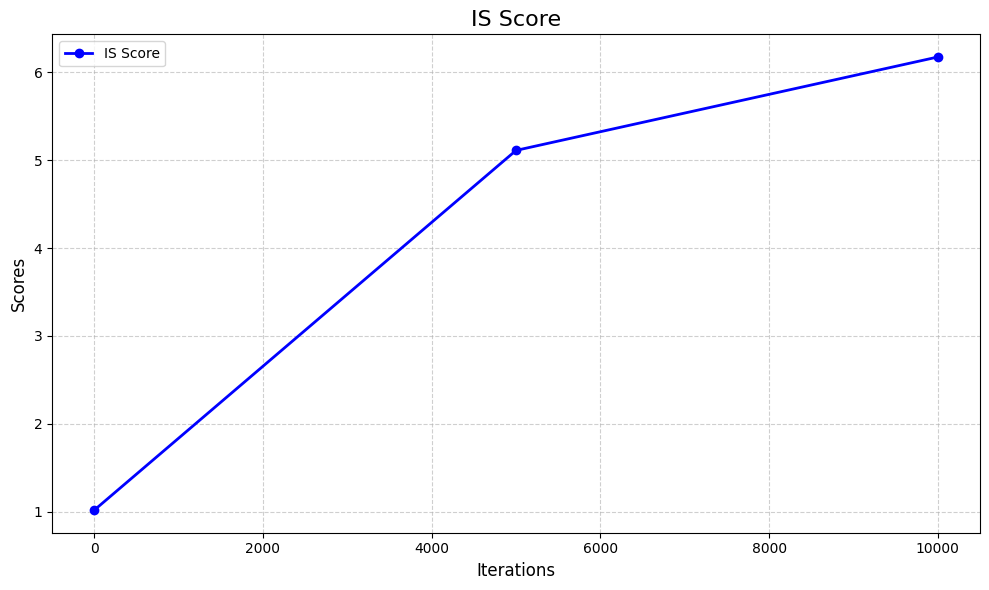

In [29]:
converted_data = [[item[0], item[1][0]] for item in IS_scores]
plot_graph(converted_data,'IS Score', 'Iterations', 'Scores' )

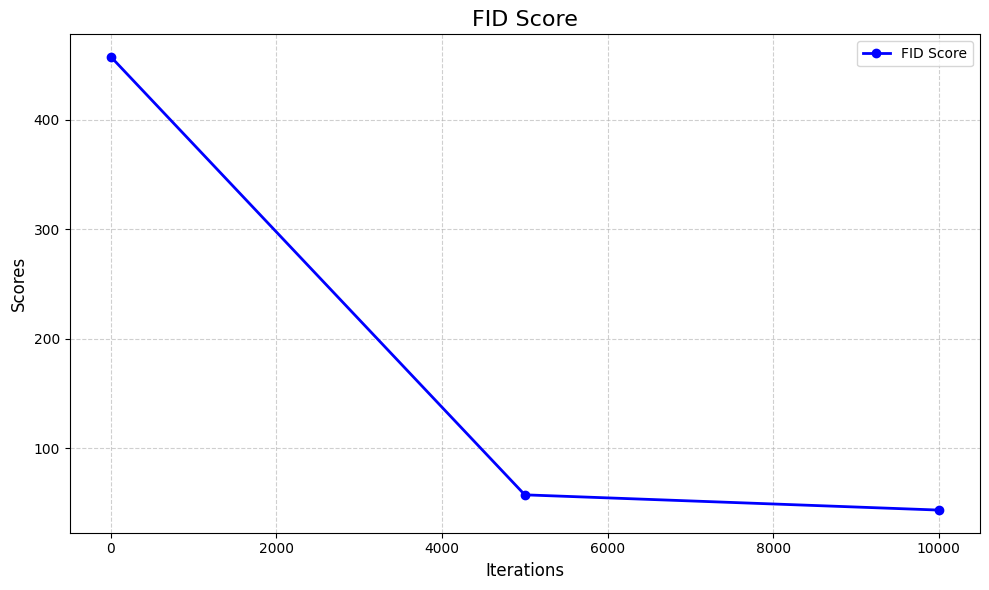

In [30]:
plot_graph(fid_scores, 'FID Score', 'Iterations', 'Scores')

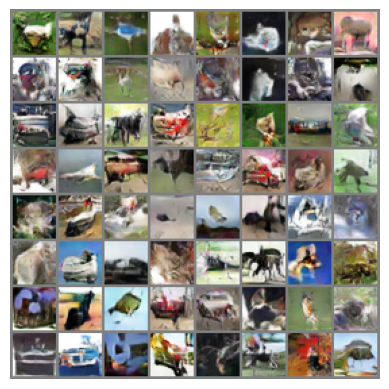

In [31]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image from the uploaded file or a specific directory
image_path = '/content/logs/SNGAN_CIFAR10_RES/sample/9500.png'  # Replace with the name or path of your uploaded image

# Open and display the image
img = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()

# Conclusion

The results already look quite promising. The training has been run over 20000 iterations. As in the graph we can see that FID score is decreasing and Inception score is increasing.This is a good indicator that the model is learning well.

The final FID score and IS score after 10000 iterations are as following.
Inception Score: 6.176(0.04591),  FID: 43.622

=======================================================================================================================================================================================================